In [1]:
import importlib
import covidStream

from psaw import PushshiftAPI
import oauth, tweepy, praw
from youtube_api import YouTubeDataAPI

from wordcloud import WordCloud, STOPWORDS 
import json
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import datetime as dt
import time, functools, operator
from collections import Counter

from bs4 import BeautifulSoup
from requests import get

import networkx as nx

### Twitter, Youtube and Reddit API Setup

In [2]:
with open("Credentials/redditCredentials.json", "r") as redditFile:
    redditCredentials = json.load(redditFile)

In [3]:
reddit = praw.Reddit(client_id=redditCredentials['client_id'], \
                     client_secret=redditCredentials['client_secret'], \
                     user_agent='test', \
                     username=redditCredentials['username'], \
                     password=redditCredentials['password'])

psawAPI = PushshiftAPI(reddit)

In [4]:
with open("Credentials/twitterCredentials.json", "r") as twitterFile:
    twitterCredentials = json.load(twitterFile)

In [5]:
auth = tweepy.OAuthHandler(twitterCredentials['consumer_key'], twitterCredentials['consumer_secret'])
auth.set_access_token(twitterCredentials['access_key'], twitterCredentials['access_secret'])
twitterAPI = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [6]:
with open("Credentials/youtubeCredentials.json", "r") as youtubeFile:
    youtubeCredentials = json.load(youtubeFile)

In [7]:
youtubeAPI = YouTubeDataAPI(youtubeCredentials['api_key'])

### Collect the submissions between two specified dates (startEpoch and endEpoch) from the Coronavirus subreddit

In [8]:
startTime = time.time()
startEpoch = int(dt.datetime(2020, 3, 10).timestamp())
endEpoch = int(dt.datetime(2020, 3, 23).timestamp())

submissionList = list(psawAPI.search_submissions(after=startEpoch,
                                                 before=endEpoch,
                                                 subreddit='Coronavirus',
                                                 filter=['url','author', 'title', 'created_utc']))

print("Time: ", time.time() - startTime)

/home/aminmekacher/.local/lib/python3.7/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 502
  warnings.warn("Got non 200 code %s" % response.status_code)
/home/aminmekacher/.local/lib/python3.7/site-packages/psaw/PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")


Time:  1368.8014605045319


### Twitter Analysis: Country detection and data scraping (# followers, screen name, date)

In [13]:
importlib.reload(covidStream)
twitterSub = [submission for submission in submissionList if 'https://twitter.com/' in submission.url]
twitterDF = covidStream.collect_urls('twitter', twitterSub, twitterAPI, youtubeAPI)
twitterDF.to_csv('twitterDF.csv')

Rate limit reached. Sleeping for: 3
Rate limit reached. Sleeping for: 20
Rate limit reached. Sleeping for: 89
Rate limit reached. Sleeping for: 180


### Disinformation Analysis: Gathering of the controversial articles shared on r/Coronavirus, and analysis of the users sharing them

In [9]:
scienceWebsites = ['fivethirtyeight.com', 'livescience.com', 'wired.com', 'sciencealert.com']
chineseWebsites = ['weibo.cn', 'cgtn.com', 'globaltimes.cn', 'chinadaily.com.cn']

scienceSub = [submission for submission in submissionList if any(science in submission.url for science in scienceWebsites)]
chineseSub = [submission for submission in submissionList if any(chinese in submission.url for chinese in chineseWebsites)]
infowarsSub = [submission for submission in submissionList if 'infowars.com' in submission.url]
foxSub = [submission for submission in submissionList if 'foxnews.com' in submission.url]

scienceUsers = [{'user': submission.author.name, 'website': submission.url} for submission in scienceSub if submission.author is not None]
chineseUsers = [{'user': submission.author.name, 'website': submission.url} for submission in chineseSub if submission.author is not None]
infowarsUsers = [{'user': submission.author.name, 'website': submission.url} for submission in infowarsSub if submission.author is not None]
foxUsers = [{'user': submission.author.name, 'website': submission.url} for submission in foxSub if submission.author is not None]

#### Science Graph

In [10]:
importlib.reload(covidStream)
scienceGraph = covidStream.create_social_network(scienceUsers[0:20], psawAPI, submissionsAnalysis=True, commentsAnalysis=False)

/home/aminmekacher/.local/lib/python3.7/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 502
  warnings.warn("Got non 200 code %s" % response.status_code)
/home/aminmekacher/.local/lib/python3.7/site-packages/psaw/PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")


In [11]:
nx.write_gexf(scienceGraph, "Gephi Files/scienceNetwork.gexf")

#### Fox News Graph

In [16]:
importlib.reload(covidStream)
foxGraph = covidStream.create_social_network(foxUsers[0:20], psawAPI, submissionsAnalysis=True, commentsAnalysis=False)

In [17]:
nx.write_gexf(foxGraph, "Gephi Files/foxNetwork.gexf")

#### InfoWars Graph

In [27]:
importlib.reload(covidStream)
infowarsGraph = covidStream.create_social_network(infowarsUsers[0:20], psawAPI, submissionsAnalysis=True, commentsAnalysis=False)

In [28]:
nx.write_gexf(infowarsGraph, "Gephi Files/infowarsNetwork.gexf")

#### Chinese Propaganda Graph

In [20]:
importlib.reload(covidStream)
chineseGraph = covidStream.create_social_network(chineseUsers[0:20], psawAPI, submissionsAnalysis=True, commentsAnalysis=False)

Exact:  Supposedly leaked Overwatch 2 images [Imge] Frocharocha PS4
Exact2:  Leaked Overwtch 2 Pictures Frocharocha Blizzard
Exact:  Monster Hunter World: Iceborne - Gamescom 2019 Trailer [HD 1080P] Frocharocha MonsterHunter
Exact2:  Monster Hunter World: Iceborne - Gamescom 2019 Trailer [HD 1080P] Frocharocha MonsterHunterWorld
Exact:  Rin the Goddess Frocharocha fatestaynight
Exact2:  Fighting Gold but Google Translated through 23 languages Frocharocha Animemes
Exact:  Community Day in NA is officialy over Frocharocha TheSilphRoad
Exact2:  Kobayashi Dragon's Slut Frocharocha Animemes


In [21]:
nx.write_gexf(chineseGraph, "Gephi Files/chineseNetwork.gexf")

### Analysis of the activity of users of interest

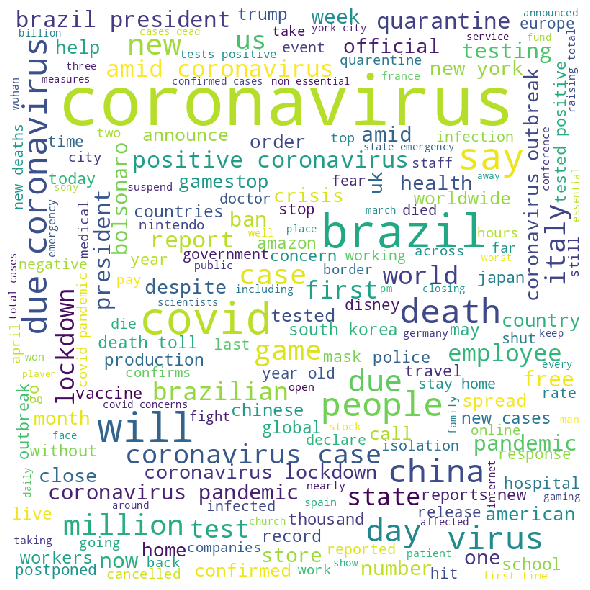

In [9]:
importlib.reload(covidStream)
covidStream.user_activity_wordcloud('Frocharocha', psawAPI, submissionsAnalysis=True, subreddits='Coronavirus')

In [8]:
psawAPI.redditor_subreddit_activity('Frocharocha')

{'comment': Counter({'Animemes': 1459,
          'anime': 1343,
          'bowsette': 1196,
          'DarlingInTheFranxx': 1175,
          'NintendoSwitch': 847,
          'xboxone': 840,
          'fatestaynight': 755,
          'Earthchan': 638,
          'pcgaming': 595,
          'pokemon': 585,
          'PS4': 554,
          'shieldbro': 455,
          'GoblinSlayer': 446,
          'Planetchan': 384,
          'Booette': 271,
          'OnePunchMan': 260,
          'pokemongo': 255,
          'cosplaygirls': 194,
          'movies': 191,
          'worldnews': 177,
          'gaming': 169,
          'PS5': 160,
          'Coronavirus': 154,
          'grandorder': 135,
          'SuicideWatch': 131,
          'DeathStranding': 117,
          'KimetsuNoYaiba': 115,
          'VioletEvergarden': 112,
          'residentevil': 108,
          'cyberpunkgame': 86,
          'AskReddit': 75,
          'banned': 69,
          'FinalFantasy': 65,
          'nintendo': 65,
          'te

In [24]:
donaldList, hillaryList = [], []

In [30]:
for scienceUser in scienceUsers:
    print(scienceUser['user'])
    donaldSubs = list(psawAPI.search_submissions(author=scienceUser['user'], subreddit='The_Donald'))
    if len(donaldSubs) > 0:
        donaldList.append([submission.title for submission in donaldSubs])
        
    hillarySubs = list(psawAPI.search_submissions(author=scienceUser['user'], subreddit='HillaryForPrison'))
    if len(hillarySubs) > 0:
        hillaryList.append([submission.title for submission in hillarySubs])

geordilaforge
ssldvr
TheMexicanJuan
Gambit08
barber5
dwysywd1
kjvlv
The_Meat_Gazer
sgrnetworking
novahunter
alleyjohn
tcfritz
jlott069
Canuknucklehead
Iarguewithretards
CorporateCuster
username1615
IanMazgelis
GetOutOfTheWhey
rayQuGR
Mihai4544
Mihai4544
808hunna
Oh-B-cereus
CaptainSkull2030
sc2003
futureAlgorithm
bdubchile
jscix
quantumcipher
DelicateDream
geordilaforge
DoozerMarch
MaxSRL
WarSanchez
drewiepoodle
therightnews
therightnews
eurydicey
Katalopa
masonlikeskfc
probabilitydoughnut
wonderwah
limsus
El_Pizz
vsbobclear
Lochd0wn
Super-Saiyan-Singh
NAME7355


/home/aminmekacher/.local/lib/python3.7/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
/home/aminmekacher/.local/lib/python3.7/site-packages/psaw/PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")


Ihoardtoiletpaper
Canuknucklehead
theringoshow
Phaethonas
13_letter
badgalori
createkaos
Kathalysa
gainswor
P1ffP4ff
_fortunate_man
ninjascotsman
Yasushi2018
RedJohnIsBacc
cactuselephantt
chowyun3
Pilgrimaging420
keepmyheadhigh
BlankVerse
Cyruslego
Milkyway42093
Viewfromthe31stfloor
zoomkatz
TheKeyboardKid
Ecstatic_Direction
limsus
gfz728374
jcepiano
GayDarknessSpirit
no1_vern
cncrndctzn2
RedMeGold
SweetSwitzerland
shallah
Canuknucklehead
writerkamalsingh
thonioand
CrackHeadRodeo
artbycommittee
24KPureHot
wee_man
blackguygreg
BenJTho
arabahrami
hoeskioeh
vv4life
DataPatata
bjpopp
ZeroHealth
minawolf


In [31]:
hillaryList

[['September 23',
  '[Serious] Is the FBI going to release the transcript of their interview with Hillary Clinton?',
  'WHAT THE FUCK IS JULIAN ASSANGE DOING',
  'Remember everyone, DO NOT BRIGADE the Hillary Clinton subreddit! Watching them try to put spin on it is too hilarious to risk them locking a thread.',
  "No matter how inappropriate Bill meeting with Loretta Lynch was, let's not ignore the big point: He went to the attorney general to beg not to prosecute. Sounds like the FBI investigation isn't nothing after all.",
  "A Hillary supporter's first instinct when asked about the emails is to point out that George Bush's adminstration did something similar. George W Bush. Think about that.",
  "Julian Assange should put up a progress bar on how long it'll take to leak his Hillary documents",
  "What's your WikiLeaks wish list?",
  'Has Julian Assange given a release window?',
  "Hillary's defense of having a private server",
  "Hillary's new campaign manager",
  "Do you ever get 